In [35]:
%%time
import sys;
#!{sys.executable} -m  pip list --outdated --format=freeze | grep -v '^\-e' | cut -d = -f 1  | xargs -n1 pip install -U
#!{sys.executable} -m pip install -r requirements.txt
#!{sys.executable} -m pip install --upgrade scikit-learn


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 10 µs


In [36]:
%%time
import boto3
import sagemaker

session = sagemaker.Session() 
region = session.boto_region_name 

bucket = 'sagemaker-jfox'
 
prefix = 'sagemaker/xgboost'
role = sagemaker.get_execution_role()

print('Bucket {} in region {}'.format(bucket, region))

Bucket sagemaker-jfox in region eu-west-1
CPU times: user 30.7 ms, sys: 38 µs, total: 30.7 ms
Wall time: 67.6 ms


In [37]:
%%time
import random
import pandas as pd
raw_data_filename = 'fraudhead.csv'

s3 = boto3.resource('s3', region_name=region)
#s3.Bucket(bucket).download_file(raw_data_filename, raw_data_filename)
percent_to_read=1.0
fraction_to_read=percent_to_read/100 # Divide by 1000 and not 100 as expected?
#nrows=10_000_000# There are 6.3 million lines in the original
df = pd.read_csv('./'+raw_data_filename,  skiprows=lambda i: i>0 and random.random() > fraction_to_read)
df = pd.read_csv('./'+raw_data_filename)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 1000)

print('Length', len(df))
target_col='isFraud'
df

Length 999
CPU times: user 19.3 ms, sys: 232 µs, total: 19.5 ms
Wall time: 23.6 ms


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
994,1,PAYMENT,1617.90,C1004430079,507865.0,506247.10,M1379148981,0.0,0.0,0,0
995,1,PAYMENT,2167.26,C732597634,13669.0,11501.74,M832432849,0.0,0.0,0,0
996,1,PAYMENT,9738.95,C2031927175,289748.0,280009.05,M176041373,0.0,0.0,0,0
997,1,PAYMENT,3396.25,C1967617997,18524.0,15127.75,M726843606,0.0,0.0,0,0


Counts of each class to determine imbalance

In [38]:
fraud_len=len(  df.loc[  df[target_col]  ==1  ])
not_fraud_len=len(df)-fraud_len
print('Fraud', fraud_len, 'Not fraud', not_fraud_len, "total", len(df))

Fraud 9 Not fraud 990 total 999


In [39]:
df=df.drop(['isFlaggedFraud'], axis=1)

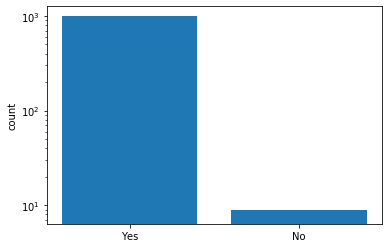

In [40]:
import math
import matplotlib.pyplot as plt   
def plot_positive_negative_counts(df, target_col):
    val_counts=df[target_col].value_counts()
    fig, ax = plt.subplots()
    ax.set(yscale="log")
    plt.bar(['Yes', 'No'], val_counts)
    plt.ylabel('count')
    plt.show()
    
plot_positive_negative_counts(df,target_col)

Make dummies (onehot) for 'type' field

In [41]:
cols = df.columns.tolist()
cols.remove(target_col)
cols = [target_col] + cols
df = df[cols]# Move target to the left

df_dummies=pd.get_dummies(df['type'],drop_first=True )

df=df.drop(['type'], axis=1)
df = pd.concat([df, df_dummies], axis=1)
 

**HashingEncoder** to handle categorical columns with high cardinality. These cannot be onehotted as that would generate too many columns and a too-sparse matrix.

In [42]:
%%time

#import sys
#!{sys.executable} -m pip install numpy category_encoders

import category_encoders as ce  
hashencode_these = ['nameOrig', 'nameDest']
columns_before = [x for x in df.columns if x not in hashencode_these+[target_col]]

def make_col_mapping(cols):
    col_mapping = {}
    for c in cols:
        if c[:4]=='col_':
          num = c.split('_')[-1]
          int(num) # check format
          col_mapping[c] = hashencode_this + "_" + num
     
    return col_mapping


def hashencode(hashencode_this, df, previous_hash_cols):
    for c in df.columns:
        assert c[:4]!="col_",  df.columns
                
    ce_hash = ce.HashingEncoder(cols = [hashencode_this])
    X1 = df.drop([target_col], axis=1)
    y1 = df[target_col]
    with_hashing = ce_hash.fit_transform(X1, y1)
    hashed = with_hashing.drop(columns_before+previous_hash_cols, axis=1)
    generated_cols = [x for x in hashed.columns if x[:4]=='col_']
    col_mapping = make_col_mapping(generated_cols)
    
    hashed = hashed.rename(columns = col_mapping)
    df = pd.concat([y1, X1, hashed], axis=1)
 
    df = df.drop([hashencode_this], axis=1)
    return df, list(col_mapping.values())
 
previous_hash_cols = []
for hashencode_this in hashencode_these: 
   df, previous_hash_cols = hashencode(hashencode_this,df,previous_hash_cols)

df

CPU times: user 2.46 s, sys: 75.6 ms, total: 2.54 s
Wall time: 2.72 s


,isFraud,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,CASH_OUT,DEBIT,PAYMENT,...,nameOrig_6,nameOrig_7,nameDest_0,nameDest_1,nameDest_2,nameDest_3,nameDest_4,nameDest_5,nameDest_6,nameDest_7
0,0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,2,0,0
1,0,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,...,0,0,2,0,0,0,0,0,0,0
2,1,1,181.00,181.0,0.00,0.0,0.0,0,0,0,...,0,1,0,0,2,0,0,0,0,0
3,1,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,...,0,0,0,0,0,0,0,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,0,1,1617.90,507865.0,506247.10,0.0,0.0,0,0,1,...,0,0,0,0,0,2,0,0,0,0
995,0,1,2167.26,13669.0,11501.74,0.0,0.0,0,0,1,...,0,0,0,0,2,0,0,0,0,0
996,0,1,9738.95,289748.0,280009.05,0.0,0.0,0,0,1,...,0,0,0,0,2,0,0,0,0,0
997,0,1,3396.25,18524.0,15127.75,0.0,0.0,0,0,1,...,0,0,0,0,0,2,0,0,0,0


*SMOTENC* for unbalanced classes. 

In [44]:
#import sys;
#!{sys.executable} -m pip install numpy imbalanced-learn
from imblearn.over_sampling import SMOTENC
#TODO: Try skipping the SMOTE and using weighting in XGBOOST
use_smote = True
if use_smote:
   ycol=target_col
   Xcol=list(df.columns)
   Xcol.remove(ycol)
 
   categorical_columns=[i for i in range(len(Xcol)) 
                     if Xcol[i] not in ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']]

   smotenc = SMOTENC(categorical_columns,random_state = 101)

   X, y = smotenc.fit_resample(df[Xcol], df[ycol])
   y_df = pd.DataFrame({target_col: y} )

   df = pd.concat([X, y_df], axis=1)

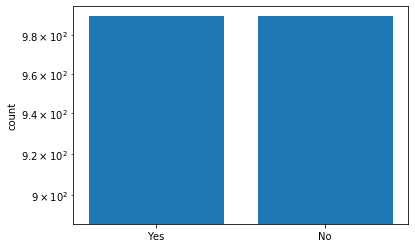

In [44]:
plot_positive_negative_counts(df,target_col)

# Split  with randomization

In [45]:
import numpy as np
len_=len(df)
train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len_), int(0.9 * len_)])

libSVM for performance

In [46]:
from sklearn.datasets import dump_svmlight_file   

for d in [(train_data, 'train.libsvm'), ( validation_data, 'validation.libsvm'), (test_data, 'test.libsvm')]:
   dataset=d[0]
   dump_svmlight_file(X=dataset.drop([target_col], axis=1), y=dataset[target_col], f=d[1])


for filename in ['train.libsvm', 'validation.libsvm']:
   s3.Bucket(bucket).Object(prefix + '/'+filename.split('.')[0]+'/'+filename).upload_file(filename)

In [47]:
def s3_path(subset):
  return sagemaker.s3_input(s3_data='s3://{}/{}/{}'.format(bucket, prefix,subset), content_type='libsvm')

s3_input_train = s3_path('train')
s3_input_validation =s3_path('validation')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


---
## Train

Our data is now ready to be used to train a XGBoost model. The XGBoost algorithm has many tunable hyperparameters. Some of these hyperparameters are listed below; initially we'll only use a few of them.  

- `max_depth`: Maximum depth of a tree. As a cautionary note, a value too small could underfit the data, while increasing it will make the model more complex and thus more likely to overfit the data (in other words, the classic bias-variance tradeoff).
- `eta`: Step size shrinkage used in updates to prevent overfitting.  
- `eval_metric`: Evaluation metric(s) for validation data. For data sets such as this one with imbalanced classes, we'll use the AUC metric.
- `scale_pos_weight`: Controls the balance of positive and negative weights, again useful for data sets having imbalanced classes.

First we'll set up the parameters for an Amazon SageMaker Estimator object, and the hyperparameters for the algorithm itself.  The Estimator object from the Amazon SageMaker Python SDK is a convenient way to set up training jobs with a minimal amount of code.

In [48]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(region, 'xgboost','1.0-1')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='fraud-detection-job',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=session)

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Run the hosted training job itself.

In [49]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-11-07 18:28:51 Starting - Starting the training job...
2020-11-07 18:28:53 Starting - Launching requested ML instances......
2020-11-07 18:29:57 Starting - Preparing the instances for training......
2020-11-07 18:31:20 Downloading - Downloading input data
2020-11-07 18:31:20 Training - Downloading the training image...
2020-11-07 18:31:47 Uploading - Uploading generated training model
2020-11-07 18:31:47 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value auc to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
[18:31:37] 1386x26 matrix with 8495 entries loaded from /opt/ml/input/d

---
## Host

Now that we've trained the XGBoost algorithm on our data, we can deploy the trained model to an Amazon SageMaker hosted endpoint with one simple line of code.

In [50]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                          instance_type='ml.m5.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

---

## Evaluation

Now that we have our hosted endpoint, we can generate predictions from  the  test data set.

Compared actual to predicted values of whether the transaction was a "fraud" (`1`) or not (`0`).  Then we'll produce a  confusion matrix.

In [51]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [52]:
%%time
import json

with open('test.libsvm', 'r') as f:
    payload = f.read().strip()

labels = [int(line.split(' ')[0]) for line in payload.split('\n')]
test_data = [line for line in payload.split('\n')]
preds = batch_predict(test_data, 100)

print ('\nError rate=%f' % ( sum(1 for i in range(len(preds)) if preds[i]!=labels[i]) /float(len(preds))))

..
Error rate=0.000000
CPU times: user 17.3 ms, sys: 0 ns, total: 17.3 ms
Wall time: 160 ms


In [53]:
pd.crosstab(index=np.array(labels), columns=np.array(preds))

col_0,0,1
row_0,,
0,100,0
1,0,98


In [54]:
session.delete_endpoint(xgb_predictor.endpoint)